<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/ToyCircleRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#create image of circle, log values of theta or scaled [0,1]

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


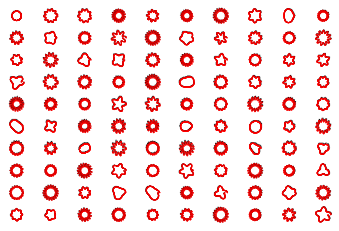

In [2]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    #img = img.T
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            pred = model(sample).view(1000,3)
            print('pred', pred.shape)
            predres = numpoints
            X = pred[:,0]
            Y = pred[:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            print("type",type(X))
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)
        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            #print(c[(int)(el[1]),(int)(el[0])].item())
            #assert c[(int)(el[1]),(int)(el[0])].item() == 1
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [3]:
a = dataset[1]
c = a[0]
print(a[1].shape)
for el in a[1]:
  print(c[(int)(el[1]),(int)(el[0])])

torch.Size([1000, 3])
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)

In [4]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_dim = 1*32*32+1
        """self.control_pointsy =  nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Sigmoid()
        )"""
        

        

        

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, 2),
            nn.Sigmoid()
        )

    def forward(self, x,thetas):
        #print(thetas.shape)
        thetas = thetas.unsqueeze(1)
        assert thetas.shape == (64,1)
        x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        x = torch.cat([x,thetas], dim=1)
        #print(x.shape)
        assert x.shape == (mini_batch,self.hidden_dim)
        out = self.mlp(x)
        return 32.0*out

In [5]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [6]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [7]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
epoch = 10
for e in range(epoch):
  for xin,yin in loader_train:
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    x = yin[:,:,0]
    y = yin[:,:,1]
    t = np.array([np.linspace(0,1,1000) for i in range(64)])
    z = t
    # spline parameters
    s=1 # smoothness parameter
    k=3 # spline order
    nest=-1 # estimate of number of knots needed (-1 = maximal)

    numpoints = x.shape[1]
    scaledthetas = [(float)(i/numpoints) for i in range(numpoints)]
    scaledthetas = [scaledthetas for i in range(mini_batch)]
    scaledthetas = np.array(scaledthetas)
    scaledthetas = torch.from_numpy(scaledthetas).float().cuda()
    assert torch.max(scaledthetas) <= 1
    #print(xin.shape,scaledthetas.shape)
    """
    for i in range(numpoints):
      out = model(xin,scaledthetas[:,i])
      loss = torch.mean((out[:,0]-x[:,i])**2+(out[:,1]-y[:,i])**2)
      loss.backward()
      optimizer.step()
    """
    for ind in range(numpoints):
      out = model(xin,scaledthetas[:,ind])
      loss = torch.mean((out[:,0]-x[:,ind])**2+(out[:,1]-y[:,ind])**2)
      loss.backward()
      optimizer.step()


    print(loss)
    


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(86.8806, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(84.7373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(89.5894, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(89.9248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(86.2056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(84.1191, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(89.1570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(93.5206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(86.6649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(89.6862, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(83.8841, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(87.5145, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(92.6448, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(85.6905, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(94.8356, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(95.1838, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(89.9077, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(87.3449

KeyboardInterrupt: ignored

In [9]:
a = torch.zeros(64,1)
b = torch.zeros(64,1024)
c = torch.cat([a,b], dim=1)
c.shape

torch.Size([64, 1025])

In [9]:
###

I think I need to give the model the first x0,y0 coordinate in addition to all the other information.
